<a href="https://colab.research.google.com/github/javiera-ari/javiera./blob/main/Time%20Series/Time%20Series%20Analysis_PCesarAstudillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import IPython.core.display
import matplotlib ## paquete necesario para poder hacer gráficas

def apply_styles(): ### especificamos los parámetros para los gráficos
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles() ### finalmente aplicamos el estilo

In [10]:
### éstos elementos configuran fuente tamaño color de la letra porcentaje etc.
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 1. Look into the data
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [2]:
import warnings ## desactivan los mensajes para ciertos advertencias en las funciones
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [3]:
import pandas as pd
## la siguiente línea indica la dirección donde se encuentran los datos que queremos cargarla siguiente línea indica la dirección donde se encuentran los datos que queremos cargar
### si te fijas bien la dirección corresponde precisamente al proyecto github que acabamos de cargar
## solamente que apunta a un archivo CSV

url="https://raw.githubusercontent.com/castudil/Machine-Learning/main/data/GMAA-040218.csv"
## Básicamente tomamos ese archivo y lo cargamos usando un método que lo transfiere hacia un data frame
df = pd.read_csv(url, header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [4]:
df.head(5)

,period,value
0,1980-01-01,739
1,1980-02-01,602
2,1980-03-01,740
3,1980-04-01,1028
4,1980-05-01,1088


In [5]:
df.shape ## permite ver las dimensiones de los datos mostrándonos primero a las filas y luego a las columnas

(454, 2)

In [6]:
df.describe ##  nos permite tener una noción de qué datos se almacenan en cada columna

<bound method NDFrame.describe of         period  value
0   1980-01-01    739
1   1980-02-01    602
2   1980-03-01    740
3   1980-04-01   1028
4   1980-05-01   1088
..         ...    ...
449 2017-06-01   3556
450 2017-07-01   3981
451 2017-08-01   3902
452 2017-09-01   3066
453 2017-10-01   3140

[454 rows x 2 columns]>

In [7]:
max_date = df.period.max() ## accedemos al periodo y obtenemos el máximo valor de la fecha
min_date = df.period.min() ## acá hacemos lo análogo pero con el mínimo

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1980 - 01.10.2017
Number of data points: 454 of expected 454


El número de instancias esperadas coinciden con las que existen realmente en el conjunto de datos. En otras palabras no hay datos faltantes

### Visualize the data

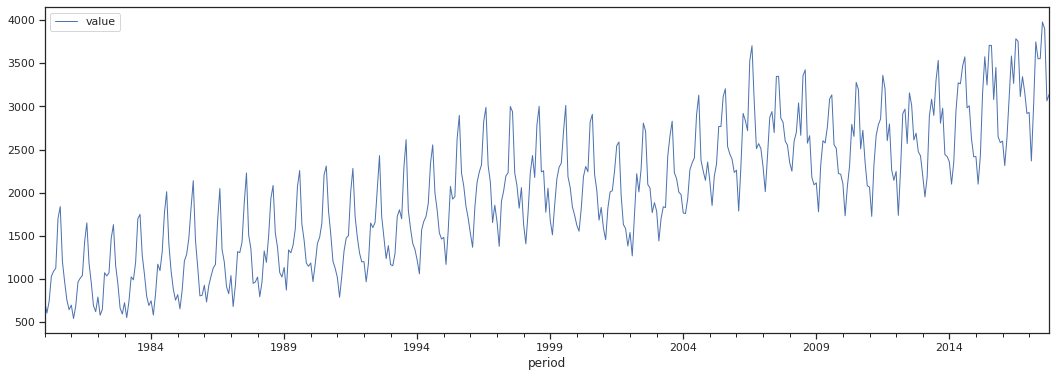

In [15]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')

plt.savefig('images/intro-visualization.png'); ## recuerda crear la carpeta 'images'

#Vemos claramente ver el factor estacional, pero también se percibe el ciclo, que ocurre a más largo plazo
## bien se ve una tendencia al alza

In **2001** a combination of the outbreak of foot and mouth disease and the September 11 attacks in the US led to a dramatic slump.

In **2009** the global economic crisis, which started to bite in earnest in the autumn, was blamed as a factor for the fall. 

https://www.theguardian.com/business/2009/jul/16/tourism-uk-visitors-fall

In 2006 total visits to the UK by overseas residents were split fairly
equally between three purposes: holiday, visiting friends or relatives,
and business. This pattern is quite different compared with ten years
ago, when ‘holiday’ was the dominant reason

https://www.ons.gov.uk/ons/rel/ott/travel-trends/2006/travel-trends---2006.pdf

The majority of visitors were from North America, followed by tourists from France and Germany.
http://www.bbc.com/news/uk-england-london-27323755

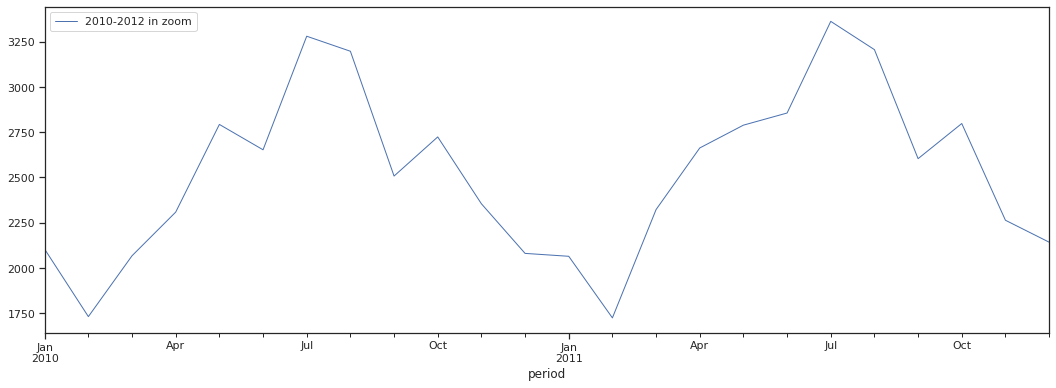

In [16]:
# hacemos una sección de los datos para analizar de cerca lo que pasa en dos años
zoom_range = df[(df.period >= '2010-01-01') & (df.period < '2012-01-01')].index

fig, ax = plt.subplots(figsize=(18,6)) # dimensiones del gráfico
df.loc[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom") ## el gráfico en sí pero considerando el zoom de datos
plt.legend(loc='upper left') # cambiamos la posición por defecto de la leyenda

plt.savefig('images/intro-zoom.png'); ## recuerda crear la carpeta 'images'

#### When is the best time to visit the UK?

The United Kingdom can be visited at any time of year ... Overall, **spring (late March to early June) and autumn (September to November) are the best times to visit**, when it’s usually warm and dry.

https://www.audleytravel.com/us/uk/best-time-to-visit

## Trend and seasonality

From the visualization it's already quite obvious that the OS visits have periodic fluctuations each year and overall tendency to grow up.

Thus, we can conclude that the time series has the **trend** and yearly **seasonality** components, and we can try to decompose them using, for instance, **statsmodels** package.

Note, from the data view we also can suspect that **additive** model better fits for data representation.

In [17]:
#Del paquete statmodel se obtiene un modelo para hacer descomposición de estacionalidad 
#explicar el paquete "statsmodels"
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [18]:
## aquí obtenemos los resultados de la descomposición, en términos de tendencia, estacionalidad y residuos
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### The Trend

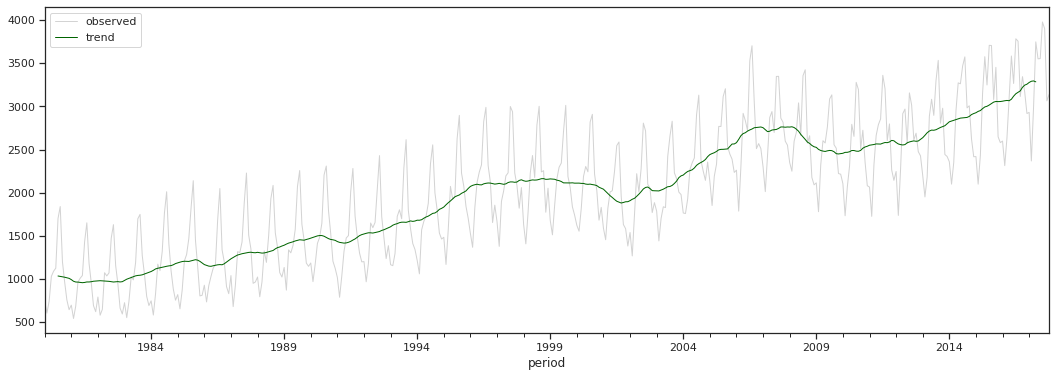

In [20]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
#grafico original
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
#grafico de la tendencia
trend.plot(ax=ax, label="trend", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')

plt.savefig('images/intro-trend.png');

### The Seasonality

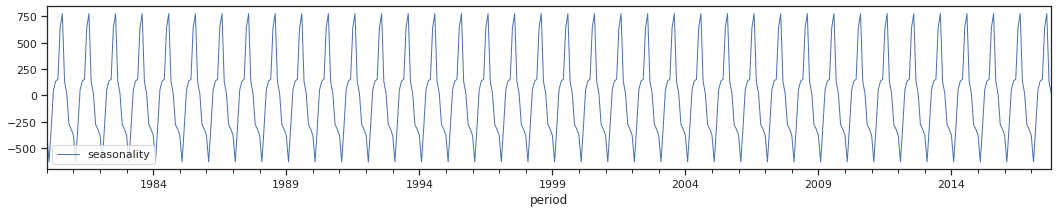

In [21]:
## ahora es el turno de graficar la estacionalidad
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="seasonality") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')

plt.savefig('images/intro-seasonality.png');

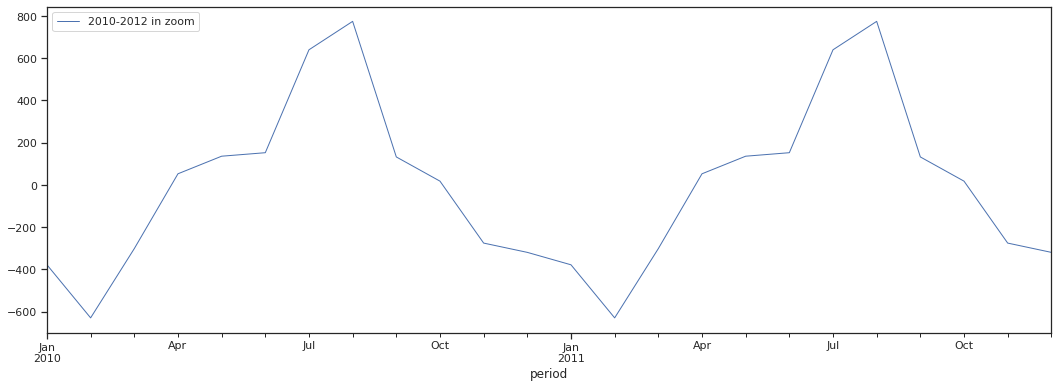

In [22]:
# Otro gráfico de la estacionalidad, pero esta vez haciendo un foco en los dos años antes mencionados, 
# entre 2010 y 2012
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

plt.savefig('images/intro-seasonality-zoom.png');

### The Residual

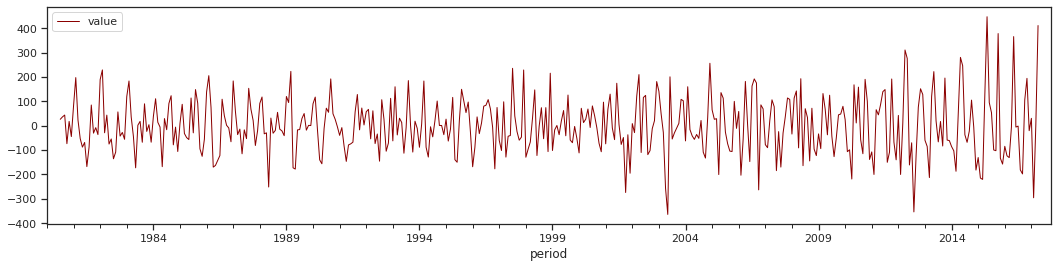

In [24]:
## finalmente gráfica vamos los elementos residuales
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred") ## Y se utiliza el objeto residual que se obtuvo en la descomposición de la serie
plt.legend(loc='upper left')

plt.savefig('images/intro-residual.png');

HASTA AQUI HAY ANALISIS DE SERIES DE TIEMPO.

AHORA HAREMOS PRONOSTICO DE SERIES DE TIEMPO.